In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.modeling import ImageDataset3D
from phase_space_reconstruction.utils import split_2screen_dset

from analysis_scripts import plot_3d_scan_data_2screens

In [2]:
# load data
data_dir = '/global/cfs/cdirs/m669/rroussel/AWA_DATA/01_18_6D_PSR/reconstruction_scan'
dset = torch.load(os.path.join(data_dir, 'dset_01_18_scan_5.pt'))

In [3]:
dset.images.shape

torch.Size([9, 2, 2, 3, 700, 700])

In [4]:
def clip_img(img, center_x, center_y, width_x, width_y):
    half_width_x = width_x // 2
    half_width_y = width_y // 2
    c_x = int(np.rint(center_x))
    c_y = int(np.rint(center_y))
    clipped_img = img[
        c_x-half_width_x:c_x+half_width_x, 
        c_y-half_width_y:c_y+half_width_y
    ]
    
    return clipped_img

def calc_centroid(img):
    img = img / torch.sum(img, axis=(-1,-2))
    centroid_x = (torch.sum(img, axis=-1) * torch.arange(img.shape[-2])).sum()
    centroid_y = (torch.sum(img, axis=-2) * torch.arange(img.shape[-1])).sum()
    return centroid_x, centroid_y

def center_and_clip_dset(dset, width_x, width_y):
    imgs = dset.images
    params = dset.params
    extra_dims = torch.tensor(imgs.shape[:-2])
    clipped_imgs_dims = torch.concatenate((extra_dims, torch.tensor([width_x, width_y]))).tolist()
    clipped_imgs = torch.zeros(clipped_imgs_dims)
    for i in range(imgs.shape[0]):
        for j in range(imgs.shape[1]):
            for k in range(imgs.shape[2]):
                for l in range(imgs.shape[3]):
                    img = imgs[i,j,k,l]
                    c_x, c_y = calc_centroid(img)
                    clipped_imgs[i,j,k,l] = clip_img(img, c_x, c_y, width_x, width_y)
                    
    return ImageDataset3D(params, clipped_imgs)

In [5]:
test_img = dset.images[3,0,1,1]
torch.tensor(test_img.shape)

tensor([700, 700])

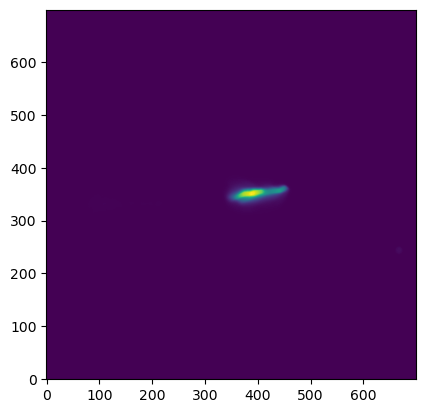

In [6]:
plt.imshow(test_img.T, origin='lower')

In [7]:
c_x, c_y = calc_centroid(test_img)
print(c_x)
print(c_y)

tensor(392.0465, dtype=torch.float64)
tensor(349.3821, dtype=torch.float64)


In [8]:
test_img_clipped = clip_img(test_img, c_x, c_y, 300, 300)

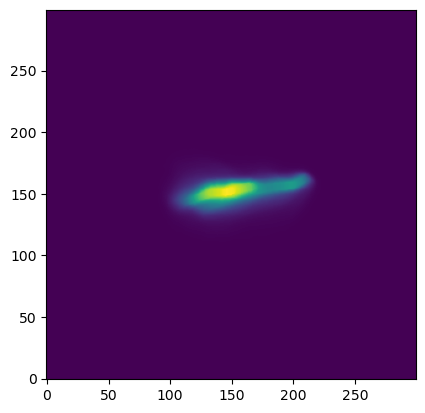

In [9]:
plt.imshow(test_img_clipped.T, origin='lower')

In [10]:
clipped_dset = center_and_clip_dset(dset, 300, 300)

(<Figure size 2000x1000 with 50 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

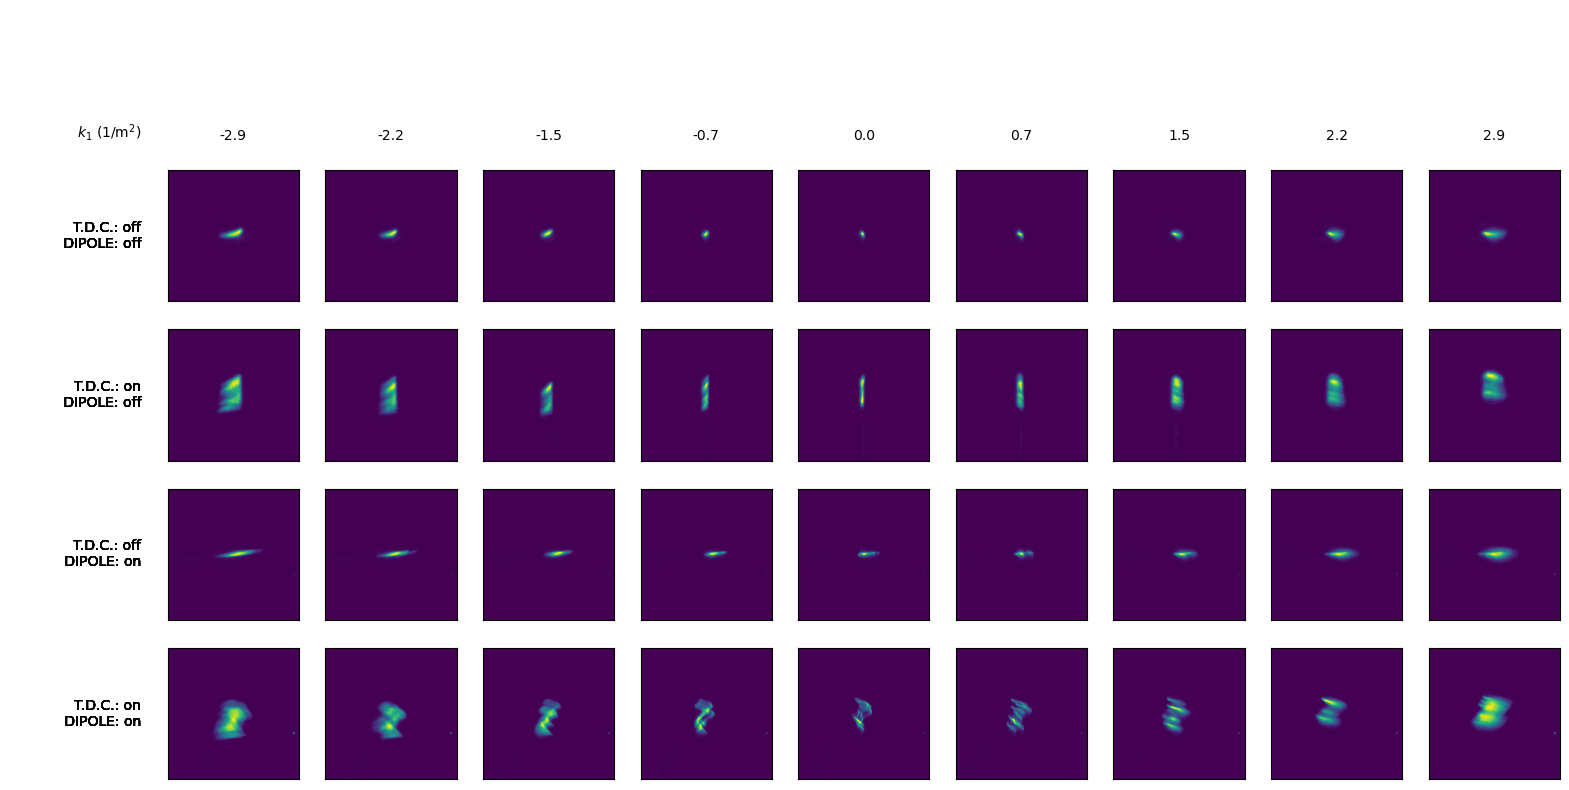

In [11]:
# plot initial dset
plot_3d_scan_data_2screens(dset)

(<Figure size 2000x1000 with 50 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

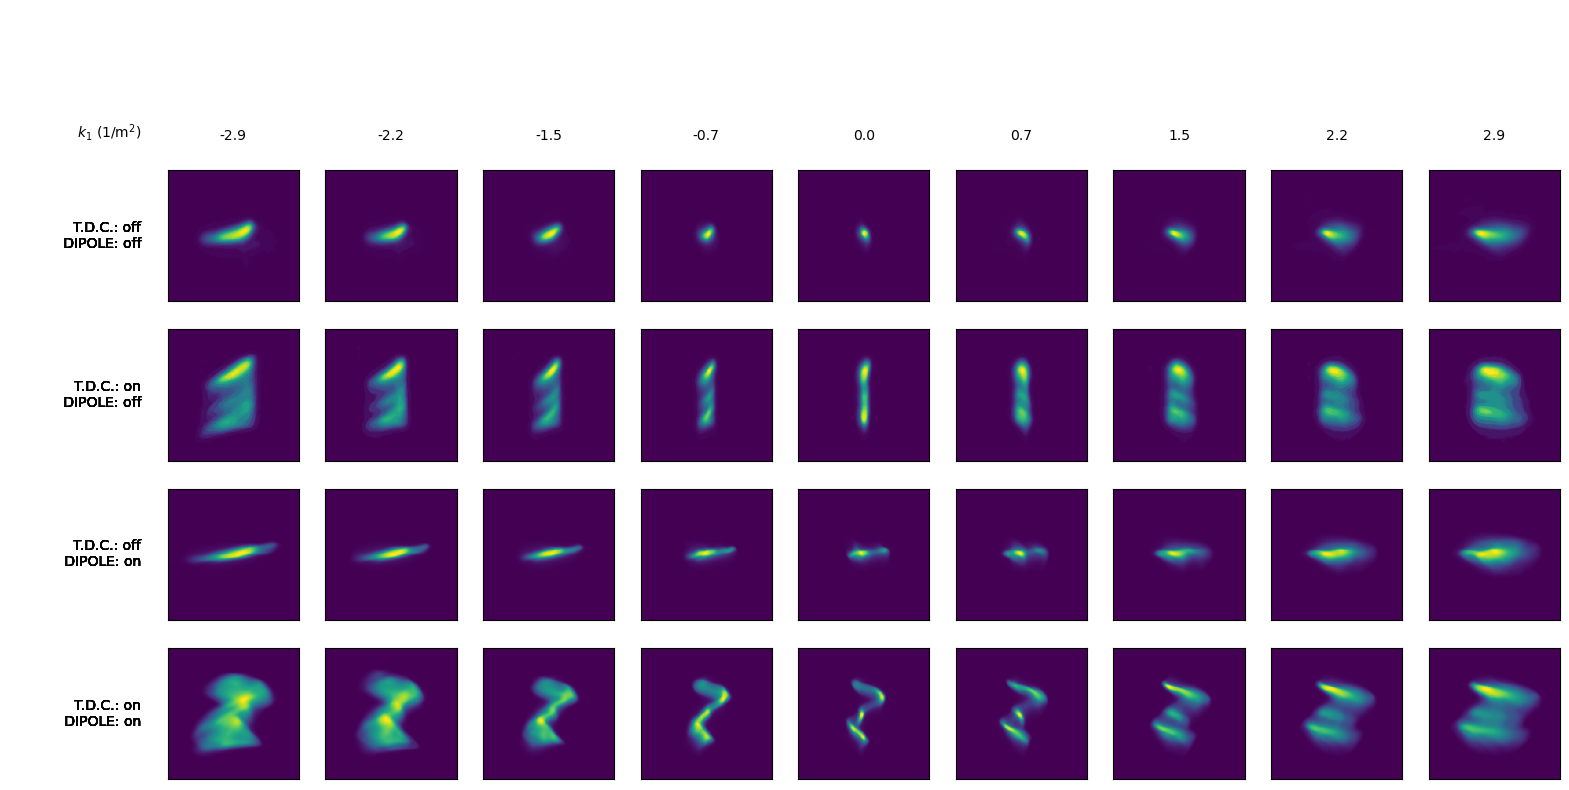

In [12]:
# plot centroid centered and clipped dset
plot_3d_scan_data_2screens(clipped_dset)

In [13]:
# save clipped dset
torch.save(clipped_dset, 'clipped_dset.pt')